# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [1]:
# !pip3 -qq install torch==0.4.1
# !pip3 -qq install bokeh==0.13.0
# !pip3 -qq install gensim==3.6.0
# !pip3 -qq install nltk
# !pip3 -qq install scikit-learn==0.20.2

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    print('Using CUDA :)')
    from torch.cuda import FloatTensor, LongTensor
else:
    print('Using CPU :(')
    from torch import FloatTensor, LongTensor

np.random.seed(42)

Using CUDA :)


In [18]:
import math
from tqdm import tqdm

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [3]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /home/apollo/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/apollo/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [4]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [5]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

wc_train = sum(len(sent) for sent in train_data)
wc_val = sum(len(sent) for sent in val_data)
wc_test = sum(len(sent) for sent in test_data)

print(f'Sentences count in train/val/test: {len(train_data)}/{len(val_data)}/{len(test_data)}')
print(f'Words count in train/val/test: {wc_train}/{wc_val}/{wc_test}')

Sentences count in train/val/test: 36554/6451/14335
Words count in train/val/test: 739769/130954/290469


Построим маппинги из слов в индекс и из тега в индекс:


In [6]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'.', 'ADV', 'X', 'CONJ', 'NUM', 'PRT', 'VERB', 'ADP', 'PRON', 'ADJ', 'NOUN', 'DET'}


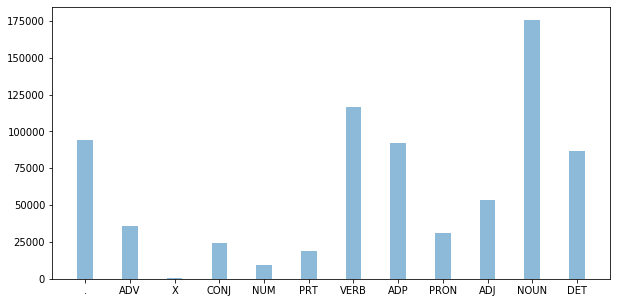

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [8]:
import nltk

default_tagger = nltk.DefaultTagger('NOUN') # Was: NN
print('Accuracy of default tagger = {:.2%}'.format(default_tagger.evaluate(test_data)))

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of default tagger = 23.68%
Accuracy of unigram tagger = 94.34%


Добавим вероятности переходов:

In [9]:
bigram_tagger = nltk.BigramTagger(train_data)
print('Accuracy of bigram tagger w/o backoff = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger with backoff = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger w/o backoff = 42.54%
Accuracy of bigram tagger with backoff = 95.14%


Обратите внимание, что `backoff` важен:

In [10]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger w/o backoff = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

trigram_tagger = nltk.TrigramTagger(train_data, backoff=bigram_tagger)
print('Accuracy of trigram tagger with backoff = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger w/o backoff = 23.33%
Accuracy of trigram tagger with backoff = 95.15%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [11]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [12]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,29514,45335.0,26924.0,18946.0,22980.0,19998.0,27858.0,7556.0,11394.0,11720.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17799,36693.0,12380.0,34255.0,26447.0,14038.0,27604.0,26447.0,36192.0,2899.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41592,17922.0,13412.0,21518.0,16227.0,40385.0,25247.0,3520.0,43376.0,3513.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31679,23661.0,28355.0,28328.0,43866.0,35347.0,26447.0,22659.0,23661.0,15078.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,29514,28247.0,12682.0,13947.0,44997.0,27930.0,16022.0,7365.0,5231.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
pd.DataFrame(y_train).head()

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,160
0,1,12.0,7.0,9.0,7.0,8.0,11.0,11.0,8.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8,12.0,11.0,8.0,12.0,10.0,8.0,12.0,10.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,11.0,7.0,2.0,7.0,7.0,8.0,12.0,7.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,10.0,11.0,2.0,7.0,8.0,12.0,10.0,10.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,9.0,7.0,2.0,1.0,1.0,7.0,11.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [15]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

In [16]:
X_batch

array([[21593.,  2910.,  2591., 26447.],
       [34418.,  6907., 27604.,   431.],
       [34255., 27930., 44027., 22549.],
       [26447., 28406., 25755., 29895.],
       [ 1064., 14905., 34255., 27930.],
       [27930., 18221., 29144., 36693.],
       [26447., 37178., 27930.,  8575.],
       [ 8091., 43150., 24031., 32316.],
       [25247., 38031., 32866., 32545.],
       [45172., 26447., 26447., 42279.],
       [27930., 28091., 15289., 27930.],
       [ 9663.,  9176., 11394., 32545.],
       [15195., 27930., 26447., 31392.],
       [ 5231., 12541., 43121.,   299.],
       [    0., 31281., 21655., 10320.],
       [    0., 42992., 27930., 22714.],
       [    0., 10150., 26447., 27604.],
       [    0., 11394., 10196., 16227.],
       [    0., 26447., 11394., 15554.],
       [    0., 32426., 32924.,  4432.],
       [    0., 11394.,  9495., 34255.],
       [    0., 19845.,  7787., 19769.],
       [    0.,  5231., 38102.,  5231.],
       [    0.,     0., 12279.,     0.],
       [    0., 

In [17]:
y_batch

array([[ 3., 11.,  7., 12.],
       [11., 11.,  8., 11.],
       [ 8.,  1., 11.,  7.],
       [12.,  9.,  2., 10.],
       [11.,  7.,  8.,  1.],
       [ 1., 11., 11., 12.],
       [12.,  3.,  1., 11.],
       [11.,  3., 11., 10.],
       [ 8.,  8.,  7.,  4.],
       [11., 12., 12.,  7.],
       [ 1.,  7., 11.,  1.],
       [ 9., 11.,  8.,  4.],
       [ 7.,  1., 12.,  6.],
       [ 1.,  7., 10.,  7.],
       [ 0.,  5., 11.,  2.],
       [ 0.,  2.,  1.,  7.],
       [ 0., 10., 12.,  6.],
       [ 0.,  8., 11.,  7.],
       [ 0., 12.,  8., 10.],
       [ 0., 11., 12., 11.],
       [ 0.,  8., 12.,  8.],
       [ 0., 11., 11.,  9.],
       [ 0.,  1.,  7.,  1.],
       [ 0.,  0.,  7.,  0.],
       [ 0.,  0.,  7.,  0.],
       [ 0.,  0.,  7.,  0.],
       [ 0.,  0.,  9.,  0.],
       [ 0.,  0.,  2.,  0.],
       [ 0.,  0., 12.,  0.],
       [ 0.,  0., 10.,  0.],
       [ 0.,  0., 11.,  0.],
       [ 0.,  0.,  1.,  0.]])

**Задание** Реализуйте `LSTMTagger`:

In [39]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1, verbose=False):
        super().__init__()
        
        self.verbose = verbose
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count)
        self.linear = nn.Linear(in_features=lstm_hidden_dim, out_features=tagset_size)    

    def forward(self, inputs):
        if self.verbose:
            print(f'Input shape: {inputs.shape}')
            
        embedding_res = self.embedding(inputs)
        if self.verbose:
            print(f'Embedding shape: {embedding_res.shape}')
        
        lstm_res, _ = self.lstm(embedding_res)
        if self.verbose:
            print(f'LSTM output shape: {lstm_res.shape}')
        
        linear_res = self.linear(lstm_res)
        if self.verbose:
            print(f'Prediction shape: {linear_res.shape}')
        
        return linear_res        

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [92]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
    verbose=True
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

indices = torch.argmax(logits, -1)

mask = y_batch.bool().float()
match = (indices == y_batch).float()
correct_samples = torch.sum(match * mask)
total_samples = torch.sum(mask)
accuracy = correct_samples/total_samples

print(f'\nPrediction shape: {logits.shape}')
print(f'True labels shape: {y_batch.shape}')

print(f'\nAccuracy: {accuracy:.4f}')

Input shape: torch.Size([32, 4])
Embedding shape: torch.Size([32, 4, 100])
LSTM output shape: torch.Size([32, 4, 128])
Prediction shape: torch.Size([32, 4, 13])

Prediction shape: torch.Size([32, 4, 13])
True labels shape: torch.Size([32, 4])

Accuracy: 0.0761


In [96]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='mean').cuda()

logits_4loss = torch.transpose(torch.transpose(logits, 0, 1), 1, 2)
y_batch_4loss = torch.transpose(y_batch, 0, 1)

loss = criterion(logits_4loss, y_batch_4loss)

print(f'Loss: {loss:.4f}')

Loss: 2.5737


**Задание** Вставьте эти вычисление в функцию:

In [19]:
def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)

                logits_4loss = torch.transpose(torch.transpose(logits, 0, 1), 1, 2)
                y_batch_4loss = torch.transpose(y_batch, 0, 1)
                loss = criterion(logits_4loss, y_batch_4loss)
                indices = torch.argmax(logits, -1)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                                
                mask = y_batch.bool().float()
                match = (indices == y_batch).float()
                cur_correct_count = torch.sum(match * mask)
                cur_sum_count = torch.sum(mask)

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, 
        epochs_count=1, batch_size=32, 
        val_data=None, val_batch_size=None, 
        scheduler=None, scheduler_loss=False):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')
            
        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()

In [173]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1.5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True)

fit(model, criterion, optimizer, train_data=(X_train, y_train), 
    epochs_count=50, batch_size=64, 
    val_data=(X_val, y_val), val_batch_size=512,
    scheduler=scheduler, scheduler_loss=True)

[1 / 50] Train: Loss = 0.77425, Accuracy = 75.08%: 100%|██████████| 572/572 [00:04<00:00, 119.81it/s]
[1 / 50]   Val: Loss = 0.49991, Accuracy = 83.28%: 100%|██████████| 13/13 [00:00<00:00, 150.32it/s]
[2 / 50] Train: Loss = 0.42691, Accuracy = 85.62%: 100%|██████████| 572/572 [00:04<00:00, 116.82it/s]
[2 / 50]   Val: Loss = 0.38644, Accuracy = 86.90%: 100%|██████████| 13/13 [00:00<00:00, 132.25it/s]
[3 / 50] Train: Loss = 0.33299, Accuracy = 88.85%: 100%|██████████| 572/572 [00:04<00:00, 121.52it/s]
[3 / 50]   Val: Loss = 0.30540, Accuracy = 89.33%: 100%|██████████| 13/13 [00:00<00:00, 144.74it/s]
[4 / 50] Train: Loss = 0.25188, Accuracy = 91.69%: 100%|██████████| 572/572 [00:04<00:00, 116.66it/s]
[4 / 50]   Val: Loss = 0.24288, Accuracy = 91.55%: 100%|██████████| 13/13 [00:00<00:00, 147.33it/s]
[5 / 50] Train: Loss = 0.18765, Accuracy = 93.90%: 100%|██████████| 572/572 [00:04<00:00, 119.17it/s]
[5 / 50]   Val: Loss = 0.19640, Accuracy = 93.12%: 100%|██████████| 13/13 [00:00<00:00, 13

Epoch    21: reducing learning rate of group 0 to 3.3300e-04.


[23 / 50] Train: Loss = 0.06919, Accuracy = 97.80%: 100%|██████████| 572/572 [00:04<00:00, 137.71it/s]
[23 / 50]   Val: Loss = 0.12040, Accuracy = 95.97%: 100%|██████████| 13/13 [00:00<00:00, 136.12it/s]
[24 / 50] Train: Loss = 0.06678, Accuracy = 97.92%: 100%|██████████| 572/572 [00:04<00:00, 138.95it/s]
[24 / 50]   Val: Loss = 0.12319, Accuracy = 95.94%: 100%|██████████| 13/13 [00:00<00:00, 152.09it/s]
[25 / 50] Train: Loss = 0.06696, Accuracy = 97.93%: 100%|██████████| 572/572 [00:04<00:00, 140.67it/s]
[25 / 50]   Val: Loss = 0.12106, Accuracy = 95.97%: 100%|██████████| 13/13 [00:00<00:00, 129.77it/s]
[26 / 50] Train: Loss = 0.06667, Accuracy = 97.93%: 100%|██████████| 572/572 [00:03<00:00, 146.08it/s]
[26 / 50]   Val: Loss = 0.12177, Accuracy = 95.92%: 100%|██████████| 13/13 [00:00<00:00, 139.64it/s]
[27 / 50] Train: Loss = 0.06607, Accuracy = 97.94%: 100%|██████████| 572/572 [00:04<00:00, 136.06it/s] 
[27 / 50]   Val: Loss = 0.12382, Accuracy = 95.96%: 100%|██████████| 13/13 [00:0

Epoch    26: reducing learning rate of group 0 to 1.1089e-04.


[28 / 50] Train: Loss = 0.05974, Accuracy = 98.18%: 100%|██████████| 572/572 [00:04<00:00, 128.66it/s]
[28 / 50]   Val: Loss = 0.12221, Accuracy = 95.99%: 100%|██████████| 13/13 [00:00<00:00, 148.91it/s]
[29 / 50] Train: Loss = 0.05929, Accuracy = 98.21%: 100%|██████████| 572/572 [00:04<00:00, 122.79it/s]
[29 / 50]   Val: Loss = 0.12130, Accuracy = 95.97%: 100%|██████████| 13/13 [00:00<00:00, 151.90it/s]
[30 / 50] Train: Loss = 0.05915, Accuracy = 98.24%: 100%|██████████| 572/572 [00:04<00:00, 130.99it/s]
[30 / 50]   Val: Loss = 0.12204, Accuracy = 95.94%: 100%|██████████| 13/13 [00:00<00:00, 130.73it/s]
[31 / 50] Train: Loss = 0.05899, Accuracy = 98.25%: 100%|██████████| 572/572 [00:04<00:00, 120.80it/s]
[31 / 50]   Val: Loss = 0.12328, Accuracy = 95.94%: 100%|██████████| 13/13 [00:00<00:00, 142.74it/s]
[32 / 50] Train: Loss = 0.06469, Accuracy = 98.49%:   5%|▍         | 27/572 [00:00<00:03, 139.36it/s]

Epoch    30: reducing learning rate of group 0 to 3.6926e-05.


[32 / 50] Train: Loss = 0.05623, Accuracy = 98.34%: 100%|██████████| 572/572 [00:04<00:00, 123.51it/s]
[32 / 50]   Val: Loss = 0.12414, Accuracy = 95.94%: 100%|██████████| 13/13 [00:00<00:00, 139.97it/s]
[33 / 50] Train: Loss = 0.05608, Accuracy = 98.36%: 100%|██████████| 572/572 [00:04<00:00, 128.21it/s]
[33 / 50]   Val: Loss = 0.12312, Accuracy = 95.94%: 100%|██████████| 13/13 [00:00<00:00, 138.48it/s]
[34 / 50] Train: Loss = 0.05593, Accuracy = 98.37%: 100%|██████████| 572/572 [00:04<00:00, 142.62it/s]
[34 / 50]   Val: Loss = 0.12460, Accuracy = 95.93%: 100%|██████████| 13/13 [00:00<00:00, 144.77it/s]
[35 / 50] Train: Loss = 0.05593, Accuracy = 98.37%: 100%|██████████| 572/572 [00:04<00:00, 125.94it/s]
[35 / 50]   Val: Loss = 0.12512, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 138.17it/s]
[36 / 50] Train: Loss = 0.05882, Accuracy = 98.07%:   5%|▍         | 27/572 [00:00<00:04, 132.81it/s]

Epoch    34: reducing learning rate of group 0 to 1.2296e-05.


[36 / 50] Train: Loss = 0.05478, Accuracy = 98.42%: 100%|██████████| 572/572 [00:04<00:00, 119.43it/s] 
[36 / 50]   Val: Loss = 0.12463, Accuracy = 95.91%: 100%|██████████| 13/13 [00:00<00:00, 149.82it/s]
[37 / 50] Train: Loss = 0.05474, Accuracy = 98.42%: 100%|██████████| 572/572 [00:04<00:00, 122.04it/s]
[37 / 50]   Val: Loss = 0.12512, Accuracy = 95.91%: 100%|██████████| 13/13 [00:00<00:00, 142.38it/s]
[38 / 50] Train: Loss = 0.05473, Accuracy = 98.41%: 100%|██████████| 572/572 [00:04<00:00, 119.37it/s]
[38 / 50]   Val: Loss = 0.12476, Accuracy = 95.91%: 100%|██████████| 13/13 [00:00<00:00, 138.88it/s]
[39 / 50] Train: Loss = 0.05465, Accuracy = 98.43%: 100%|██████████| 572/572 [00:04<00:00, 117.10it/s]
[39 / 50]   Val: Loss = 0.12548, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 152.35it/s]
[40 / 50] Train: Loss = 0.04704, Accuracy = 98.56%:   5%|▍         | 27/572 [00:00<00:03, 138.73it/s]

Epoch    38: reducing learning rate of group 0 to 4.0947e-06.


[40 / 50] Train: Loss = 0.05431, Accuracy = 98.44%: 100%|██████████| 572/572 [00:04<00:00, 121.03it/s]
[40 / 50]   Val: Loss = 0.12524, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 141.86it/s]
[41 / 50] Train: Loss = 0.05426, Accuracy = 98.43%: 100%|██████████| 572/572 [00:04<00:00, 122.42it/s]
[41 / 50]   Val: Loss = 0.12490, Accuracy = 95.91%: 100%|██████████| 13/13 [00:00<00:00, 138.81it/s]
[42 / 50] Train: Loss = 0.05431, Accuracy = 98.44%: 100%|██████████| 572/572 [00:04<00:00, 117.38it/s]
[42 / 50]   Val: Loss = 0.12550, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 149.46it/s]
[43 / 50] Train: Loss = 0.05423, Accuracy = 98.44%: 100%|██████████| 572/572 [00:05<00:00, 108.76it/s]
[43 / 50]   Val: Loss = 0.12511, Accuracy = 95.89%: 100%|██████████| 13/13 [00:00<00:00, 148.11it/s]
[44 / 50] Train: Loss = 0.05782, Accuracy = 98.13%:   4%|▍         | 23/572 [00:00<00:04, 124.86it/s]

Epoch    42: reducing learning rate of group 0 to 1.3635e-06.


[44 / 50] Train: Loss = 0.05409, Accuracy = 98.44%: 100%|██████████| 572/572 [00:04<00:00, 123.93it/s]
[44 / 50]   Val: Loss = 0.12560, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 143.18it/s]
[45 / 50] Train: Loss = 0.05416, Accuracy = 98.44%: 100%|██████████| 572/572 [00:04<00:00, 118.64it/s]
[45 / 50]   Val: Loss = 0.12509, Accuracy = 95.89%: 100%|██████████| 13/13 [00:00<00:00, 147.52it/s]
[46 / 50] Train: Loss = 0.05408, Accuracy = 98.44%: 100%|██████████| 572/572 [00:04<00:00, 115.59it/s]
[46 / 50]   Val: Loss = 0.12500, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 142.70it/s]
[47 / 50] Train: Loss = 0.05412, Accuracy = 98.44%: 100%|██████████| 572/572 [00:04<00:00, 118.74it/s]
[47 / 50]   Val: Loss = 0.12528, Accuracy = 95.89%: 100%|██████████| 13/13 [00:00<00:00, 150.25it/s]
[48 / 50] Train: Loss = 0.04157, Accuracy = 98.80%:   4%|▍         | 24/572 [00:00<00:04, 128.18it/s]

Epoch    46: reducing learning rate of group 0 to 4.5406e-07.


[48 / 50] Train: Loss = 0.05414, Accuracy = 98.45%: 100%|██████████| 572/572 [00:05<00:00, 114.39it/s]
[48 / 50]   Val: Loss = 0.12502, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 129.23it/s]
[49 / 50] Train: Loss = 0.05402, Accuracy = 98.44%: 100%|██████████| 572/572 [00:04<00:00, 115.20it/s] 
[49 / 50]   Val: Loss = 0.12505, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 143.39it/s]
[50 / 50] Train: Loss = 0.05401, Accuracy = 98.44%: 100%|██████████| 572/572 [00:04<00:00, 116.30it/s]
[50 / 50]   Val: Loss = 0.12540, Accuracy = 95.90%: 100%|██████████| 13/13 [00:00<00:00, 143.44it/s]


### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [27]:
def compute_loss_accuracy(model, criterion, data, batch_size=512):    
    model.eval() # Evaluation mode
    
    with torch.no_grad():    
        loss_accum = 0.0
        correct_count = 0.0
        sum_count = 0.0
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
            X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
            logits = model(X_batch)       
            
            logits_4loss = torch.transpose(torch.transpose(logits, 0, 1), 1, 2)
            y_batch_4loss = torch.transpose(y_batch, 0, 1)
            loss = criterion(logits_4loss, y_batch_4loss)
            indices = torch.argmax(logits, -1)
            
            loss_accum += loss.item()
            
            mask = y_batch.bool().float()
            match = (indices == y_batch).float()
            cur_correct_count = torch.sum(match * mask)
            cur_sum_count = torch.sum(mask)

            correct_count += cur_correct_count
            sum_count += cur_sum_count
    
    return loss_accum / (i + 1), correct_count / sum_count

In [175]:
test_loss, test_accuracy = compute_loss_accuracy(model, criterion, data=(X_test, y_test))
print('Test: Loss = {:.5f}, Accuracy = {:.2%}'.format(test_loss, test_accuracy))

Test: Loss = 0.12384, Accuracy = 96.00%


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [177]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1, verbose=False):
        super().__init__()
        
        self.verbose = verbose
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count, 
                            bidirectional=True)
        self.linear = nn.Linear(in_features=2*lstm_hidden_dim, out_features=tagset_size)    

    def forward(self, inputs):
        if self.verbose:
            print(f'Input shape: {inputs.shape}')
            
        embedding_res = self.embedding(inputs)
        if self.verbose:
            print(f'Embedding shape: {embedding_res.shape}')
        
        lstm_res, _ = self.lstm(embedding_res)
        if self.verbose:
            print(f'LSTM output shape: {lstm_res.shape}')
        
        linear_res = self.linear(lstm_res)
        if self.verbose:
            print(f'Prediction shape: {linear_res.shape}')
        
        return linear_res  

In [178]:
model = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
    verbose=True
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

indices = torch.argmax(logits, -1)

mask = y_batch.bool().float()
match = (indices == y_batch).float()
correct_samples = torch.sum(match * mask)
total_samples = torch.sum(mask)
accuracy = correct_samples/total_samples

print(f'\nPrediction shape: {logits.shape}')
print(f'True labels shape: {y_batch.shape}')

print(f'\nAccuracy: {accuracy:.4f}')

Input shape: torch.Size([32, 4])
Embedding shape: torch.Size([32, 4, 100])
LSTM output shape: torch.Size([32, 4, 256])
Prediction shape: torch.Size([32, 4, 13])

Prediction shape: torch.Size([32, 4, 13])
True labels shape: torch.Size([32, 4])

Accuracy: 0.1304


In [189]:
model_bi = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model_bi.parameters(), lr=1e-3, weight_decay=1.35e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True)

fit(model_bi, criterion, optimizer, train_data=(X_train, y_train), 
    epochs_count=50, batch_size=64, 
    val_data=(X_val, y_val), val_batch_size=512,
    scheduler=scheduler, scheduler_loss=True)

[1 / 50] Train: Loss = 0.62997, Accuracy = 79.89%: 100%|██████████| 572/572 [00:06<00:00, 82.30it/s]
[1 / 50]   Val: Loss = 0.38582, Accuracy = 87.06%: 100%|██████████| 13/13 [00:00<00:00, 113.57it/s]
[2 / 50] Train: Loss = 0.33059, Accuracy = 89.10%: 100%|██████████| 572/572 [00:06<00:00, 83.02it/s]
[2 / 50]   Val: Loss = 0.30252, Accuracy = 89.81%: 100%|██████████| 13/13 [00:00<00:00, 111.72it/s]
[3 / 50] Train: Loss = 0.26269, Accuracy = 91.44%: 100%|██████████| 572/572 [00:07<00:00, 79.98it/s]
[3 / 50]   Val: Loss = 0.23863, Accuracy = 92.29%: 100%|██████████| 13/13 [00:00<00:00, 111.97it/s]
[4 / 50] Train: Loss = 0.19775, Accuracy = 93.74%: 100%|██████████| 572/572 [00:07<00:00, 80.87it/s]
[4 / 50]   Val: Loss = 0.18219, Accuracy = 94.17%: 100%|██████████| 13/13 [00:00<00:00, 114.57it/s]
[5 / 50] Train: Loss = 0.14254, Accuracy = 95.59%: 100%|██████████| 572/572 [00:07<00:00, 81.71it/s]
[5 / 50]   Val: Loss = 0.14419, Accuracy = 95.44%: 100%|██████████| 13/13 [00:00<00:00, 114.75i

Epoch    15: reducing learning rate of group 0 to 3.3300e-04.


[17 / 50] Train: Loss = 0.04434, Accuracy = 98.78%: 100%|██████████| 572/572 [00:07<00:00, 78.80it/s]
[17 / 50]   Val: Loss = 0.11783, Accuracy = 96.32%: 100%|██████████| 13/13 [00:00<00:00, 113.57it/s]
[18 / 50] Train: Loss = 0.04204, Accuracy = 98.90%: 100%|██████████| 572/572 [00:07<00:00, 80.20it/s] 
[18 / 50]   Val: Loss = 0.10859, Accuracy = 96.65%: 100%|██████████| 13/13 [00:00<00:00, 114.63it/s]
[19 / 50] Train: Loss = 0.04225, Accuracy = 98.89%: 100%|██████████| 572/572 [00:07<00:00, 80.04it/s] 
[19 / 50]   Val: Loss = 0.11499, Accuracy = 96.43%: 100%|██████████| 13/13 [00:00<00:00, 114.81it/s]
[20 / 50] Train: Loss = 0.04220, Accuracy = 98.90%: 100%|██████████| 572/572 [00:07<00:00, 79.45it/s] 
[20 / 50]   Val: Loss = 0.11686, Accuracy = 96.45%: 100%|██████████| 13/13 [00:00<00:00, 110.27it/s]
[21 / 50] Train: Loss = 0.03355, Accuracy = 99.24%:   3%|▎         | 17/572 [00:00<00:06, 86.02it/s]

Epoch    19: reducing learning rate of group 0 to 1.1089e-04.


[21 / 50] Train: Loss = 0.03651, Accuracy = 99.08%: 100%|██████████| 572/572 [00:06<00:00, 86.52it/s]
[21 / 50]   Val: Loss = 0.10738, Accuracy = 96.68%: 100%|██████████| 13/13 [00:00<00:00, 117.39it/s]
[22 / 50] Train: Loss = 0.03628, Accuracy = 99.11%: 100%|██████████| 572/572 [00:07<00:00, 80.08it/s]
[22 / 50]   Val: Loss = 0.11034, Accuracy = 96.62%: 100%|██████████| 13/13 [00:00<00:00, 112.05it/s]
[23 / 50] Train: Loss = 0.03636, Accuracy = 99.12%: 100%|██████████| 572/572 [00:07<00:00, 80.29it/s]
[23 / 50]   Val: Loss = 0.11062, Accuracy = 96.63%: 100%|██████████| 13/13 [00:00<00:00, 112.59it/s]
[24 / 50] Train: Loss = 0.03637, Accuracy = 99.12%: 100%|██████████| 572/572 [00:06<00:00, 86.84it/s]
[24 / 50]   Val: Loss = 0.11710, Accuracy = 96.45%: 100%|██████████| 13/13 [00:00<00:00, 115.35it/s]
[25 / 50] Train: Loss = 0.03148, Accuracy = 99.17%:   3%|▎         | 17/572 [00:00<00:06, 91.42it/s]

Epoch    23: reducing learning rate of group 0 to 3.6926e-05.


[25 / 50] Train: Loss = 0.03381, Accuracy = 99.19%: 100%|██████████| 572/572 [00:06<00:00, 82.32it/s] 
[25 / 50]   Val: Loss = 0.11228, Accuracy = 96.53%: 100%|██████████| 13/13 [00:00<00:00, 107.70it/s]
[26 / 50] Train: Loss = 0.03380, Accuracy = 99.20%: 100%|██████████| 572/572 [00:07<00:00, 80.08it/s]
[26 / 50]   Val: Loss = 0.11475, Accuracy = 96.47%: 100%|██████████| 13/13 [00:00<00:00, 112.98it/s]
[27 / 50] Train: Loss = 0.03380, Accuracy = 99.21%: 100%|██████████| 572/572 [00:06<00:00, 84.73it/s]
[27 / 50]   Val: Loss = 0.11426, Accuracy = 96.50%: 100%|██████████| 13/13 [00:00<00:00, 109.15it/s]
[28 / 50] Train: Loss = 0.03390, Accuracy = 99.20%: 100%|██████████| 572/572 [00:07<00:00, 79.88it/s]
[28 / 50]   Val: Loss = 0.11368, Accuracy = 96.53%: 100%|██████████| 13/13 [00:00<00:00, 117.37it/s]
[29 / 50] Train: Loss = 0.02137, Accuracy = 99.73%:   3%|▎         | 19/572 [00:00<00:05, 99.88it/s]

Epoch    27: reducing learning rate of group 0 to 1.2296e-05.


[29 / 50] Train: Loss = 0.03294, Accuracy = 99.24%: 100%|██████████| 572/572 [00:06<00:00, 81.93it/s]
[29 / 50]   Val: Loss = 0.11454, Accuracy = 96.48%: 100%|██████████| 13/13 [00:00<00:00, 113.73it/s]
[30 / 50] Train: Loss = 0.03288, Accuracy = 99.24%: 100%|██████████| 572/572 [00:06<00:00, 82.30it/s] 
[30 / 50]   Val: Loss = 0.11422, Accuracy = 96.51%: 100%|██████████| 13/13 [00:00<00:00, 109.59it/s]
[31 / 50] Train: Loss = 0.03294, Accuracy = 99.24%: 100%|██████████| 572/572 [00:07<00:00, 79.50it/s]
[31 / 50]   Val: Loss = 0.11489, Accuracy = 96.47%: 100%|██████████| 13/13 [00:00<00:00, 113.74it/s]
[32 / 50] Train: Loss = 0.03293, Accuracy = 99.24%: 100%|██████████| 572/572 [00:07<00:00, 80.06it/s]
[32 / 50]   Val: Loss = 0.11435, Accuracy = 96.51%: 100%|██████████| 13/13 [00:00<00:00, 111.74it/s]
[33 / 50] Train: Loss = 0.04030, Accuracy = 98.83%:   3%|▎         | 16/572 [00:00<00:06, 81.27it/s]

Epoch    31: reducing learning rate of group 0 to 4.0947e-06.


[33 / 50] Train: Loss = 0.03256, Accuracy = 99.25%: 100%|██████████| 572/572 [00:06<00:00, 81.75it/s] 
[33 / 50]   Val: Loss = 0.11421, Accuracy = 96.51%: 100%|██████████| 13/13 [00:00<00:00, 114.34it/s]
[34 / 50] Train: Loss = 0.03263, Accuracy = 99.26%: 100%|██████████| 572/572 [00:07<00:00, 80.18it/s]
[34 / 50]   Val: Loss = 0.11410, Accuracy = 96.51%: 100%|██████████| 13/13 [00:00<00:00, 113.60it/s]
[35 / 50] Train: Loss = 0.03265, Accuracy = 99.25%: 100%|██████████| 572/572 [00:07<00:00, 81.24it/s] 
[35 / 50]   Val: Loss = 0.11435, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 116.40it/s]
[36 / 50] Train: Loss = 0.03258, Accuracy = 99.25%: 100%|██████████| 572/572 [00:06<00:00, 82.31it/s] 
[36 / 50]   Val: Loss = 0.11451, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 112.53it/s]
[37 / 50] Train: Loss = 0.02634, Accuracy = 99.56%:   3%|▎         | 17/572 [00:00<00:06, 91.72it/s]

Epoch    35: reducing learning rate of group 0 to 1.3635e-06.


[37 / 50] Train: Loss = 0.03252, Accuracy = 99.26%: 100%|██████████| 572/572 [00:07<00:00, 81.52it/s]
[37 / 50]   Val: Loss = 0.11494, Accuracy = 96.50%: 100%|██████████| 13/13 [00:00<00:00, 115.64it/s]
[38 / 50] Train: Loss = 0.03247, Accuracy = 99.26%: 100%|██████████| 572/572 [00:06<00:00, 83.11it/s]
[38 / 50]   Val: Loss = 0.11522, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 119.03it/s]
[39 / 50] Train: Loss = 0.03249, Accuracy = 99.26%: 100%|██████████| 572/572 [00:06<00:00, 87.85it/s] 
[39 / 50]   Val: Loss = 0.11488, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 112.98it/s]
[40 / 50] Train: Loss = 0.03246, Accuracy = 99.26%: 100%|██████████| 572/572 [00:06<00:00, 82.70it/s] 
[40 / 50]   Val: Loss = 0.11463, Accuracy = 96.50%: 100%|██████████| 13/13 [00:00<00:00, 111.90it/s]
[41 / 50] Train: Loss = 0.03333, Accuracy = 99.06%:   3%|▎         | 18/572 [00:00<00:06, 91.93it/s]

Epoch    39: reducing learning rate of group 0 to 4.5406e-07.


[41 / 50] Train: Loss = 0.03243, Accuracy = 99.26%: 100%|██████████| 572/572 [00:06<00:00, 82.79it/s]
[41 / 50]   Val: Loss = 0.11431, Accuracy = 96.50%: 100%|██████████| 13/13 [00:00<00:00, 111.80it/s]
[42 / 50] Train: Loss = 0.03247, Accuracy = 99.26%: 100%|██████████| 572/572 [00:07<00:00, 80.81it/s]
[42 / 50]   Val: Loss = 0.11432, Accuracy = 96.50%: 100%|██████████| 13/13 [00:00<00:00, 112.42it/s]
[43 / 50] Train: Loss = 0.03240, Accuracy = 99.26%: 100%|██████████| 572/572 [00:06<00:00, 83.59it/s]
[43 / 50]   Val: Loss = 0.11520, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 111.76it/s]
[44 / 50] Train: Loss = 0.03242, Accuracy = 99.26%: 100%|██████████| 572/572 [00:07<00:00, 80.37it/s] 
[44 / 50]   Val: Loss = 0.11500, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 115.84it/s]
[45 / 50] Train: Loss = 0.04392, Accuracy = 98.91%:   3%|▎         | 17/572 [00:00<00:05, 96.86it/s]

Epoch    43: reducing learning rate of group 0 to 1.5120e-07.


[45 / 50] Train: Loss = 0.03243, Accuracy = 99.26%: 100%|██████████| 572/572 [00:07<00:00, 79.81it/s]
[45 / 50]   Val: Loss = 0.11451, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 112.58it/s]
[46 / 50] Train: Loss = 0.03244, Accuracy = 99.26%: 100%|██████████| 572/572 [00:06<00:00, 83.77it/s]
[46 / 50]   Val: Loss = 0.11495, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 112.13it/s]
[47 / 50] Train: Loss = 0.03243, Accuracy = 99.26%: 100%|██████████| 572/572 [00:07<00:00, 76.73it/s]
[47 / 50]   Val: Loss = 0.11448, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 114.76it/s]
[48 / 50] Train: Loss = 0.03243, Accuracy = 99.26%: 100%|██████████| 572/572 [00:07<00:00, 80.86it/s] 
[48 / 50]   Val: Loss = 0.11483, Accuracy = 96.49%: 100%|██████████| 13/13 [00:00<00:00, 115.54it/s]
[49 / 50] Train: Loss = 0.03279, Accuracy = 99.12%:   3%|▎         | 17/572 [00:00<00:06, 92.39it/s]

Epoch    47: reducing learning rate of group 0 to 5.0350e-08.


[49 / 50] Train: Loss = 0.03246, Accuracy = 99.26%: 100%|██████████| 572/572 [00:06<00:00, 83.04it/s]
[49 / 50]   Val: Loss = 0.11494, Accuracy = 96.50%: 100%|██████████| 13/13 [00:00<00:00, 110.34it/s]
[50 / 50] Train: Loss = 0.03241, Accuracy = 99.26%: 100%|██████████| 572/572 [00:07<00:00, 81.37it/s]
[50 / 50]   Val: Loss = 0.11454, Accuracy = 96.50%: 100%|██████████| 13/13 [00:00<00:00, 117.15it/s]


In [192]:
test_loss, test_accuracy = compute_loss_accuracy(model_bi, criterion, data=(X_test, y_test))
print('Test: Loss = {:.5f}, Accuracy = {:.2%}'.format(test_loss, test_accuracy))

Test: Loss = 0.11307, Accuracy = 96.54%


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [20]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


Построим подматрицу для слов из нашей тренировочной выборки:

In [21]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

embeddings = torch.FloatTensor(embeddings)

Know 38736 out of 45441 word embeddings


**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [23]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1, verbose=False):
        super().__init__()
        
        self.verbose = verbose
        
        word_emb_dim = w2v_model.vectors.shape[1]
        
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=True)
        self.lstm = nn.LSTM(input_size=word_emb_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count, 
                            bidirectional=True)
        self.linear = nn.Linear(in_features=2*lstm_hidden_dim, out_features=tagset_size)    
        
    def forward(self, inputs):
        if self.verbose:
            print(f'Input shape: {inputs.shape}')
            
        embedding_res = self.embedding(inputs)
        if self.verbose:
            print(f'Embedding shape: {embedding_res.shape}')
        
        lstm_res, _ = self.lstm(embedding_res)
        if self.verbose:
            print(f'LSTM output shape: {lstm_res.shape}')
        
        linear_res = self.linear(lstm_res)
        if self.verbose:
            print(f'Prediction shape: {linear_res.shape}')
            
        return linear_res  

In [24]:
model_embs = LSTMTaggerWithPretrainedEmbs(
    embeddings=embeddings,
    tagset_size=len(tag2ind),
    verbose=True
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model_embs(X_batch)

indices = torch.argmax(logits, -1)

mask = y_batch.bool().float()
match = (indices == y_batch).float()
correct_samples = torch.sum(match * mask)
total_samples = torch.sum(mask)
accuracy = correct_samples/total_samples

print(f'\nPrediction shape: {logits.shape}')
print(f'True labels shape: {y_batch.shape}')

print(f'\nAccuracy: {accuracy:.4f}')

Input shape: torch.Size([32, 4])
Embedding shape: torch.Size([32, 4, 100])
LSTM output shape: torch.Size([32, 4, 128])
Prediction shape: torch.Size([32, 4, 13])

Prediction shape: torch.Size([32, 4, 13])
True labels shape: torch.Size([32, 4])

Accuracy: 0.0435


In [213]:
model_embs = LSTMTaggerWithPretrainedEmbs(
    lstm_hidden_dim=128,
    embeddings=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model_embs.parameters(), lr=1e-3, weight_decay=0.5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True); scheduler_loss=True
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.333); scheduler_loss=False

fit(model_embs, criterion, optimizer, train_data=(X_train, y_train), 
    epochs_count=50, batch_size=64, 
    val_data=(X_val, y_val), val_batch_size=512,
    scheduler=scheduler, scheduler_loss=scheduler_loss)

[1 / 50] Train: Loss = 0.46975, Accuracy = 86.27%: 100%|██████████| 572/572 [00:06<00:00, 87.74it/s]
[1 / 50]   Val: Loss = 0.23248, Accuracy = 93.04%: 100%|██████████| 13/13 [00:00<00:00, 112.57it/s]
[2 / 50] Train: Loss = 0.16958, Accuracy = 94.97%: 100%|██████████| 572/572 [00:06<00:00, 87.93it/s]
[2 / 50]   Val: Loss = 0.16469, Accuracy = 94.95%: 100%|██████████| 13/13 [00:00<00:00, 113.08it/s]
[3 / 50] Train: Loss = 0.12553, Accuracy = 96.24%: 100%|██████████| 572/572 [00:06<00:00, 86.47it/s]
[3 / 50]   Val: Loss = 0.13700, Accuracy = 95.78%: 100%|██████████| 13/13 [00:00<00:00, 108.23it/s]
[4 / 50] Train: Loss = 0.10457, Accuracy = 96.85%: 100%|██████████| 572/572 [00:06<00:00, 84.36it/s]
[4 / 50]   Val: Loss = 0.12229, Accuracy = 96.14%: 100%|██████████| 13/13 [00:00<00:00, 111.21it/s]
[5 / 50] Train: Loss = 0.09208, Accuracy = 97.21%: 100%|██████████| 572/572 [00:06<00:00, 87.88it/s]
[5 / 50]   Val: Loss = 0.11844, Accuracy = 96.28%: 100%|██████████| 13/13 [00:00<00:00, 109.88i

Epoch    22: reducing learning rate of group 0 to 3.3300e-04.


[24 / 50] Train: Loss = 0.04423, Accuracy = 98.70%: 100%|██████████| 572/572 [00:06<00:00, 86.88it/s] 
[24 / 50]   Val: Loss = 0.08726, Accuracy = 97.23%: 100%|██████████| 13/13 [00:00<00:00, 106.02it/s]
[25 / 50] Train: Loss = 0.04353, Accuracy = 98.74%: 100%|██████████| 572/572 [00:06<00:00, 88.25it/s]
[25 / 50]   Val: Loss = 0.08792, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 111.02it/s]
[26 / 50] Train: Loss = 0.04317, Accuracy = 98.75%: 100%|██████████| 572/572 [00:06<00:00, 85.05it/s]
[26 / 50]   Val: Loss = 0.08789, Accuracy = 97.19%: 100%|██████████| 13/13 [00:00<00:00, 106.76it/s]
[27 / 50] Train: Loss = 0.04304, Accuracy = 98.76%: 100%|██████████| 572/572 [00:05<00:00, 96.38it/s] 
[27 / 50]   Val: Loss = 0.08813, Accuracy = 97.21%: 100%|██████████| 13/13 [00:00<00:00, 115.16it/s]
[28 / 50] Train: Loss = 0.04271, Accuracy = 98.76%: 100%|██████████| 572/572 [00:06<00:00, 84.77it/s]
[28 / 50]   Val: Loss = 0.08922, Accuracy = 97.17%: 100%|██████████| 13/13 [00:00<00

Epoch    27: reducing learning rate of group 0 to 1.1089e-04.


[29 / 50] Train: Loss = 0.04017, Accuracy = 98.89%: 100%|██████████| 572/572 [00:06<00:00, 85.58it/s]
[29 / 50]   Val: Loss = 0.08772, Accuracy = 97.24%: 100%|██████████| 13/13 [00:00<00:00, 111.05it/s]
[30 / 50] Train: Loss = 0.03984, Accuracy = 98.90%: 100%|██████████| 572/572 [00:06<00:00, 86.34it/s]
[30 / 50]   Val: Loss = 0.08891, Accuracy = 97.23%: 100%|██████████| 13/13 [00:00<00:00, 110.05it/s]
[31 / 50] Train: Loss = 0.03972, Accuracy = 98.90%: 100%|██████████| 572/572 [00:06<00:00, 91.42it/s] 
[31 / 50]   Val: Loss = 0.08772, Accuracy = 97.23%: 100%|██████████| 13/13 [00:00<00:00, 110.37it/s]
[32 / 50] Train: Loss = 0.03954, Accuracy = 98.91%: 100%|██████████| 572/572 [00:06<00:00, 84.56it/s]
[32 / 50]   Val: Loss = 0.08761, Accuracy = 97.23%: 100%|██████████| 13/13 [00:00<00:00, 109.33it/s]
[33 / 50] Train: Loss = 0.04724, Accuracy = 98.61%:   3%|▎         | 18/572 [00:00<00:06, 89.94it/s]

Epoch    31: reducing learning rate of group 0 to 3.6926e-05.


[33 / 50] Train: Loss = 0.03865, Accuracy = 98.95%: 100%|██████████| 572/572 [00:06<00:00, 84.82it/s]
[33 / 50]   Val: Loss = 0.08680, Accuracy = 97.24%: 100%|██████████| 13/13 [00:00<00:00, 108.80it/s]
[34 / 50] Train: Loss = 0.03864, Accuracy = 98.95%: 100%|██████████| 572/572 [00:06<00:00, 82.86it/s]
[34 / 50]   Val: Loss = 0.08701, Accuracy = 97.24%: 100%|██████████| 13/13 [00:00<00:00, 108.26it/s]
[35 / 50] Train: Loss = 0.03845, Accuracy = 98.96%: 100%|██████████| 572/572 [00:06<00:00, 83.90it/s] 
[35 / 50]   Val: Loss = 0.08725, Accuracy = 97.24%: 100%|██████████| 13/13 [00:00<00:00, 108.82it/s]
[36 / 50] Train: Loss = 0.03844, Accuracy = 98.96%: 100%|██████████| 572/572 [00:06<00:00, 83.46it/s]
[36 / 50]   Val: Loss = 0.08696, Accuracy = 97.23%: 100%|██████████| 13/13 [00:00<00:00, 112.10it/s]
[37 / 50] Train: Loss = 0.03846, Accuracy = 98.96%: 100%|██████████| 572/572 [00:06<00:00, 82.23it/s]
[37 / 50]   Val: Loss = 0.08695, Accuracy = 97.23%: 100%|██████████| 13/13 [00:00<00:

Epoch    36: reducing learning rate of group 0 to 1.2296e-05.


[38 / 50] Train: Loss = 0.03808, Accuracy = 98.98%: 100%|██████████| 572/572 [00:06<00:00, 90.68it/s] 
[38 / 50]   Val: Loss = 0.08671, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 105.34it/s]
[39 / 50] Train: Loss = 0.03801, Accuracy = 98.99%: 100%|██████████| 572/572 [00:06<00:00, 93.38it/s] 
[39 / 50]   Val: Loss = 0.08690, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 102.91it/s]
[40 / 50] Train: Loss = 0.03799, Accuracy = 98.98%: 100%|██████████| 572/572 [00:05<00:00, 101.40it/s]
[40 / 50]   Val: Loss = 0.08662, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 107.66it/s]
[41 / 50] Train: Loss = 0.03802, Accuracy = 98.98%: 100%|██████████| 572/572 [00:05<00:00, 97.78it/s] 
[41 / 50]   Val: Loss = 0.08701, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 114.72it/s]
[42 / 50] Train: Loss = 0.03797, Accuracy = 98.99%: 100%|██████████| 572/572 [00:06<00:00, 89.58it/s]
[42 / 50]   Val: Loss = 0.08707, Accuracy = 97.23%: 100%|██████████| 13/13 [00:00<

Epoch    43: reducing learning rate of group 0 to 4.0947e-06.


[45 / 50] Train: Loss = 0.03777, Accuracy = 98.99%: 100%|██████████| 572/572 [00:06<00:00, 85.89it/s]
[45 / 50]   Val: Loss = 0.08696, Accuracy = 97.21%: 100%|██████████| 13/13 [00:00<00:00, 110.39it/s]
[46 / 50] Train: Loss = 0.03778, Accuracy = 98.99%: 100%|██████████| 572/572 [00:05<00:00, 100.32it/s]
[46 / 50]   Val: Loss = 0.08680, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 112.00it/s]
[47 / 50] Train: Loss = 0.03778, Accuracy = 98.99%: 100%|██████████| 572/572 [00:06<00:00, 86.46it/s]
[47 / 50]   Val: Loss = 0.08750, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 112.06it/s]
[48 / 50] Train: Loss = 0.03777, Accuracy = 98.99%: 100%|██████████| 572/572 [00:06<00:00, 89.91it/s] 
[48 / 50]   Val: Loss = 0.08710, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 111.53it/s]
[49 / 50] Train: Loss = 0.03991, Accuracy = 99.15%:   3%|▎         | 19/572 [00:00<00:05, 99.92it/s]

Epoch    47: reducing learning rate of group 0 to 1.3635e-06.


[49 / 50] Train: Loss = 0.03772, Accuracy = 99.00%: 100%|██████████| 572/572 [00:06<00:00, 86.05it/s] 
[49 / 50]   Val: Loss = 0.08699, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 105.95it/s]
[50 / 50] Train: Loss = 0.03769, Accuracy = 99.00%: 100%|██████████| 572/572 [00:06<00:00, 84.10it/s]
[50 / 50]   Val: Loss = 0.08738, Accuracy = 97.22%: 100%|██████████| 13/13 [00:00<00:00, 108.70it/s]


**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [214]:
test_loss, test_accuracy = compute_loss_accuracy(model_embs, criterion, data=(X_test, y_test))
print('Test: Loss = {:.5f}, Accuracy = {:.2%}'.format(test_loss, test_accuracy))

Test: Loss = 0.08742, Accuracy = 97.25%
